# Feature-rich free recall analyses

### Import required libraries

In [1]:
from sqlalchemy import create_engine, MetaData, Table
import json
import pandas as pd
import numpy as np
import math
from __future__ import division
import re
import csv

### Load the data into a pandas dataframe

In [2]:
db_url = "sqlite:///participants.db"
table_name = 'turkdemo'
data_column_name = 'datastring'

# boilerplace sqlalchemy setup
engine = create_engine(db_url)
metadata = MetaData()
metadata.bind = engine
table = Table(table_name, metadata, autoload=True)

# make a query and loop through
s = table.select()
rows = s.execute()

data = []
for row in rows:
    data.append(row[data_column_name])
    
# Now we have all participant datastrings in a list.
# Let's make it a bit easier to work with:

# parse each participant's datastring as json object
# and take the 'data' sub-object
data = [json.loads(part)['data'] for part in data if part is not None]

# insert uniqueid field into trialdata in case it wasn't added
# in experiment:
for part in data:
    for record in part:
#         print(record)
        if type(record['trialdata']) is list:

            record['trialdata'] = {record['trialdata'][0]:record['trialdata'][1]}
        record['trialdata']['uniqueid'] = record['uniqueid']
        
# flatten nested list so we just have a list of the trialdata recorded
# each time psiturk.recordTrialData(trialdata) was called.
def isNotNumber(s):
    try:
        float(s)
        return False
    except ValueError:
        return True

data = [record['trialdata'] for part in data for record in part]

# filter out fields that we dont want using isNotNumber function
filtered_data = [{k:v for (k,v) in part.items() if isNotNumber(k)} for part in data]
    
# Put all subjects' trial data into a dataframe object from the
# 'pandas' python library: one option among many for analysis
data_frame = pd.DataFrame(filtered_data)

### Add a column to keep track of experiment version number

In [3]:
db_url = "sqlite:///participants.db"
table_name = 'turkdemo'
data_column_name = 'codeversion'

# boilerplace sqlalchemy setup
engine = create_engine(db_url)
metadata = MetaData()
metadata.bind = engine
table = Table(table_name, metadata, autoload=True)

# make a query and loop through
s = table.select()
rows = s.execute()

versions = []
for row in rows:
    versions.append(row[data_column_name])
    
version_col = []
for idx,sub in enumerate(data_frame['uniqueid'].unique()):
    for i in range(sum(data_frame['uniqueid']==sub)):
        version_col.append(versions[idx])
data_frame['exp_version']=version_col

### Number of subjects in each experiment

In [4]:
subids = list(data_frame[data_frame['listNumber']==15]['uniqueid'].unique())

d = dict()
for sub in subids:
    key = data_frame[data_frame['uniqueid']==sub]['exp_version'].values[0]
    if key in d:
        d[key] += 1
    else:
        d[key] = 1
print('Here is a count of how many subjects we have in each experiment: ',d)

('Here is a count of how many subjects we have in each experiment: ', {u'4.1': 1, u'1.1': 16, u'0.0': 2, u'3.2': 5, u'3.1': 14, u'1.0': 3, u'2.1': 21})


##List subject files for each experiment

In [32]:
subids = list(data_frame[data_frame['listNumber']==15]['uniqueid'].unique())

d = dict()
for sub in subids:
    key = data_frame[data_frame['uniqueid']==sub]['exp_version'].values[0]
    if key in d:
        d[key].append(sub)
    else:
        d[key]=[sub]


#reaplce these values with the experiment number
#three values for the case of experiment 1 only
print (d["0.0"], d['1.0'], d['1.1'])

([u'debugN8TPWO:debugF1XWCH', u'debugZQ55YL:debug5WQHPC'], [u'debugWF2JFB:debugPNRZFQ', u'debugLXMXTP:debugJAXRZL', u'debugQRX0V3:debugFIWAG8'], [u'debugIAU8V9:debugT1DECK', u'debug02E4FI:debugF7UOXH', u'debugGPNALW:debugXSJ1FD', u'debugS4GATI:debug2LRP6X', u'debugJAPX2W:debugFZOLSG', u'debugA98B98:debug5H8QRL', u'debugKDM8HT:debugH2I05W', u'debugQS9870:debugKM1SRC', u'debugHP65NS:debugLWS9KB', u'debugVFPD79:debugIP75FV', u'debugX84L2K:debugCDN40O', u'debugSU1T93:debugKCB9VM', u'debugE1CAO3:debugONZ2R5', u'debug8DEMRS:debugC55CO6', u'debugKUWU41:debug9FG9EP', u'debugXUZA8U:debugMR3K3X'])


### Read in word pool

In [5]:
# read in stimulus library
wordpool = pd.read_csv('stimuli/cut_wordpool.csv')

### Define data processing functions

In [6]:
# this function takes the data frame and returns subject specific data based on the subid variable
def filterData(data_frame,subid):
    filtered_stim_data = data_frame[data_frame['stimulus'].notnull() & data_frame['listNumber'].notnull()]
    filtered_stim_data = filtered_stim_data[filtered_stim_data['trial_type']=='single-stim']
    filtered_stim_data =  filtered_stim_data[filtered_stim_data['uniqueid']==subid]
    return filtered_stim_data

# this function parses the data creating an array of dictionaries, where each dictionary represents a trial (word presented) along with the stimulus attributes
def createStimDict(data):
    stimDict = []
    for index, row in data.iterrows():
        stimDict.append({
                'text': str(re.findall('>(.+)<',row['stimulus'])[0]),
                'color' : { 'r' : int(re.findall('rgb\((.+)\)',row['stimulus'])[0].split(',')[0]),
                           'g' : int(re.findall('rgb\((.+)\)',row['stimulus'])[0].split(',')[1]),
                           'b' : int(re.findall('rgb\((.+)\)',row['stimulus'])[0].split(',')[2])
                           },
                'location' : {
                    'top': float(re.findall('top:(.+)\%;', row['stimulus'])[0]),
                    'left' : float(re.findall('left:(.+)\%', row['stimulus'])[0])
                    },
                'category' : wordpool['CATEGORY'].iloc[list(wordpool['WORD'].values).index(str(re.findall('>(.+)<',row['stimulus'])[0]))],
                'size' : wordpool['SIZE'].iloc[list(wordpool['WORD'].values).index(str(re.findall('>(.+)<',row['stimulus'])[0]))],
                'wordLength' : len(str(re.findall('>(.+)<',row['stimulus'])[0])),
                'firstLetter' : str(re.findall('>(.+)<',row['stimulus'])[0])[0],
                'listnum' : row['listNumber']
            })
    return stimDict

# this function loads in the recall data into an array of arrays, where each array represents a list of words
def loadRecallData(subid):
    recalledWords = []
    for i in range(0,16):
        try:
            f = open('recall_data/' + subid + '-' + str(i) + '.wav.txt', 'rb')
            try:
                spamreader = csv.reader(f, delimiter=' ', quotechar='|')
            except:
                f = open('recall_data/' + subid + '/' + subid + '-' + str(i) + '.wav.txt', 'rb')
                spamreader = csv.reader(f, delimiter=' ', quotechar='|')
        except (IOError, OSError) as e:
            print(e)
        for row in spamreader:
            recalledWords.append(row[0].split(','))
    return recalledWords

# this function computes accuracy for a series of lists
def computeListAcc(stimDict,recalledWords):
    accVec = []
    for i in range(0,16):
        stim = [stim['text'] for stim in stimDict if stim['listnum']==i]
        recalled= recalledWords[i]
        
        acc = 0
        tmpstim = stim[:]
        for word in recalled:
            if word in tmpstim:
                tmpstim.remove(word)
                acc+=1
        accVec.append(acc/len(stim))
    return accVec

### Define fingerprint class (this will be moved to an importable module at some point)

In [7]:
# class that computes the fingerprint based on stimulus features and recall organization

# -*- coding: utf-8 -*-
import math
import numpy as np

class Pyfingerprint(object):
    '''pyfingerprint module'''

    def __init__(self, state=None, features=['category', 'size', 'firstLetter', 'wordLength', 'location', 'color', 'temporal'], weights=None, alpha=4, tau=1, sortby=None):
        self.state = state
        self.features = features
        self.weights = weights
        self.alpha = alpha
        self.tau = tau
        self.sortby = sortby

    #### public functions ####

    # given a stimulus list and recalled words, compute the weights
    def computeWeights(self, currentList, recalledWords):
        currentList = self._computeDistance(currentList)
        return self._computeFeatureWeights(currentList, recalledWords, self.features)

    def updateWeights(self,newWeights):
        if self.weights is not None:
            print('weights exist, updating..')
            for feature in self.weights: 
                self.weights[feature].append(newWeights[feature]);
        else:
            print('new weights..')
            self.weights = {};
            for feature in newWeights:
                self.weights[feature] = [];
                self.weights[feature].append(newWeights[feature]);
        print('weights: ', self.weights)

    def getReorderedList(self,nextList):
        print('Reordering list according to state: ' + str(self.state))
        if self.state == 'feature-based':
            return _featurizeList(nextList)
        elif self.state == 'random':
            return _randomizeList(nextList)
        elif self.state == 'optimal':
            return _optimizeList(nextList)
        elif self.state == 'opposite':
            return _oppositizeList(nextList)
        elif self.state == 'strip-features':
            return _stripFeatures(nextList)
        else:
            print('Warning: No fingerprint state assigned, returning same list..')
            return nextList
        
    #### private functions ####
    
    def _computeDistance(self,stimArray):
        
        # initialize distance dictionary
        for stimulus in stimArray:
            stimulus['distances'] = {}
            for feature in self.features:
                stimulus['distances'][feature] = []
                
        # loop over the lists to create distance matrices
        for i,stimulus1 in enumerate(stimArray):
            for j,stimulus2 in enumerate(stimArray):
                
                # logic for temporal clustering
                stimArray[i]['distances']['temporal'].append({
                        'word' : stimArray[j]['text'],
                        'dist' : abs(i - j)
                    })
                
                # logic for category, need to add if statement if we are using category as a feature
                stimArray[i]['distances']['category'].append({
                        'word' : stimArray[j]['text'],
                        'dist' : int(stimArray[i]['category'] != stimArray[j]['category'])
                    })

                # logic for size
                stimArray[i]['distances']['size'].append({
                    'word': stimArray[j]['text'],
                    'dist': int(stimArray[i]['size'] != stimArray[j]['size'])
                })

                # logic for first letter
                stimArray[i]['distances']['firstLetter'].append({
                    'word': stimArray[j]['text'],
                    'dist': int(stimArray[i]['firstLetter'] != stimArray[j]['firstLetter'])
                })

                # logic for word length
                stimArray[i]['distances']['wordLength'].append({
                    'word': stimArray[j]['text'],
                    'dist': abs(stimArray[i]['wordLength'] - stimArray[j]['wordLength'])
                });

                # logic for color distance
                stimArray[i]['distances']['color'].append({
                    'word': stimArray[j]['text'],
                    'dist': math.sqrt(math.pow(stimArray[i]['color']['r'] - stimArray[j]['color']['r'], 2) + math.pow(stimArray[i]['color']['g'] - stimArray[j]['color']['g'], 2) +
                        math.pow(stimArray[i]['color']['b'] - stimArray[j]['color']['b'], 2))
                });

                # logic for spatial distance
                stimArray[i]['distances']['location'].append({
                    'word': stimArray[j]['text'],
                    'dist': math.sqrt(pow(stimArray[i]['location']['top'] - stimArray[j]['location']['top'], 2) + pow(stimArray[i]['location']['left'] - stimArray[j]['location']['left'], 2))
                })
                
        return stimArray
    
    def _computeFeatureWeights(self,currentList, recalledWords, features):

        # initialize the weights object for just this list
        listWeights = {}
        for feature in self.features:
            listWeights[feature] = []

        # return default list if there is not enough data to compute the fingerprint
        if len(recalledWords) <= 2:
            print('Not enough recalls to compute fingerprint, returning default fingerprint.. (everything is .5)')
            for feature in features:
                listWeights[feature] = .5
            return listWeights
        
        # initialize pastWords list
        pastWords = []

        # finger print analysis
        for i in range(0,len(recalledWords)-1):

            # grab current word
            currentWord = recalledWords[i]

            # grab the next word
            nextWord = recalledWords[i + 1]
            
            # grab the words from the encoding list
            encodingWords = [stimulus['text'] for stimulus in currentList]
            
            # append current word to past words log
            # pastWords.append(currentWord)
            
            # if both recalled words are in the encoding list
            if (currentWord in encodingWords and nextWord in encodingWords) and (currentWord not in pastWords and nextWord not in pastWords): 
                # print(currentWord,nextWord,encodingWords,pastWords)
                

                for feature in features:

                    # get the distance vector for the current word
                    distVec = currentList[encodingWords.index(currentWord)]['distances'][feature]

                    # filter distVec removing the words that have already been analyzed from future calculations
                    filteredDistVec = []
                    for word in distVec:
                        if word['word'] in pastWords:
                            pass
                        else:
                            filteredDistVec.append(word)
                            

                    # sort distWords by distances
                    filteredDistVec = sorted(filteredDistVec, key=lambda item:item['dist'])
                    
                    # compute the category listWeights
                    nextWordIdx = [word['word'] for word in filteredDistVec].index(nextWord)

                    # not sure about this part
                    idxs = []
                    for idx,word in enumerate(filteredDistVec):
                        if filteredDistVec[nextWordIdx]['dist'] == word['dist']:
                            idxs.append(idx)

                    listWeights[feature].append(1 - (sum(idxs)/len(idxs) / len(filteredDistVec)))

                pastWords.append(currentWord)

        for feature in listWeights:
            listWeights[feature] = np.mean(listWeights[feature])

        return listWeights

In [8]:
# subjects who have completed the exp
subids = list(data_frame[data_frame['listNumber']==15]['uniqueid'].unique())

# issue with this subject - need to look into it further
subids.remove('debugGPNALW:debugXSJ1FD')
subids.remove('debug4PXFJG:debug3V9BT9')
subids.remove('debugAD2211:debugB3TKJQ')

# for each subject that completed the experiment
for idx,sub in enumerate(subids):
    
    print('Running analysis for subject: ', sub)    
        
    # get the subjects data
    filteredStimData = filterData(data_frame,sub)
    
    # parse the subjects data
    stimDict = createStimDict(filteredStimData)
    
    # load in the recall data
    recalledWords = loadRecallData(sub)
    
    # initialize the fingerprint
    pyfingerprint = Pyfingerprint()
    fingerprints= []
    
    # compute a fingerprint for each list
    for i in range(0,16):
        fingerprints.append(pyfingerprint.computeWeights([stim for stim in stimDict if stim['listnum']==i],recalledWords[i]))
        fingerprints[i]['listNum']=i
    tmp = pd.DataFrame(fingerprints)
    
    # compute accuracy
    accVec = computeListAcc(stimDict,recalledWords)
    
    # organize the data
    tmp['accuracy']=accVec
    tmp['subId']=idx
    tmp['experiment']=filteredStimData['exp_version'].values[0]
    cols = ['experiment','subId','listNum','category','color','firstLetter','location','size','wordLength','temporal','accuracy']
    
    if idx==0:
        fingerprintsDF = tmp[cols]
    else:
        fingerprintsDF = fingerprintsDF.append(tmp[cols],ignore_index=True)

fingerprintsDF['experiment'] = fingerprintsDF['experiment'].replace('0.0','1.1')

('Running analysis for subject: ', u'debugIAU8V9:debugT1DECK')
('Running analysis for subject: ', u'debug02E4FI:debugF7UOXH')
('Running analysis for subject: ', u'debugS4GATI:debug2LRP6X')
('Running analysis for subject: ', u'debugJAPX2W:debugFZOLSG')
('Running analysis for subject: ', u'debugA98B98:debug5H8QRL')
('Running analysis for subject: ', u'debugKDM8HT:debugH2I05W')
('Running analysis for subject: ', u'debugQS9870:debugKM1SRC')
('Running analysis for subject: ', u'debugHP65NS:debugLWS9KB')
('Running analysis for subject: ', u'debugVFPD79:debugIP75FV')
('Running analysis for subject: ', u'debugX84L2K:debugCDN40O')
('Running analysis for subject: ', u'debugSU1T93:debugKCB9VM')
('Running analysis for subject: ', u'debugE1CAO3:debugONZ2R5')
('Running analysis for subject: ', u'debug8DEMRS:debugC55CO6')
('Running analysis for subject: ', u'debugKUWU41:debug9FG9EP')
('Running analysis for subject: ', u'debugXUZA8U:debugMR3K3X')
('Running analysis for subject: ', u'debugGXQACE:debug6

/Users/Student/Library/Enthought/Canopy_64bit/User/lib/python2.7/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


Not enough recalls to compute fingerprint, returning default fingerprint.. (everything is .5)
('Running analysis for subject: ', u'debugWF2JFB:debugPNRZFQ')
('Running analysis for subject: ', u'debugLXMXTP:debugJAXRZL')
('Running analysis for subject: ', u'debugD7W6B2:debugFXJC2D')
Not enough recalls to compute fingerprint, returning default fingerprint.. (everything is .5)
('Running analysis for subject: ', u'debugJW0UKY:debugG9NCA3')
Not enough recalls to compute fingerprint, returning default fingerprint.. (everything is .5)
('Running analysis for subject: ', u'debugZ0R9XO:debugPR1BCU')
('Running analysis for subject: ', u'debugOSJ8VK:debugAN4K2P')
('Running analysis for subject: ', u'debugS4IOEN:debug2DXYL2')
('Running analysis for subject: ', u'debug1IV91N:debug9XYL8U')
('Running analysis for subject: ', u'debugQGWAN9:debugIZ3EEH')
('Running analysis for subject: ', u'debugTO82DJ:debugAFPD68')
('Running analysis for subject: ', u'debugP9ZZV8:debugTQS2ET')
('Running analysis for su

### Reorganize the data to play nice with seaborn

In [9]:
newData = []
for index, row in fingerprintsDF.iterrows():
    for feature in ['category','color','firstLetter','location','size','wordLength','temporal']:
        newData.append({
                'experiment': row['experiment'],
                'subId': row['subId'],
                'listNum': row['listNum'],
                'feature': feature,
                'accuracy': row['accuracy'],
                'value': row[feature]
            })
fingerprintsDF = pd.DataFrame(newData)

### import libraries and config for seaborn and statistical tests

In [10]:
import seaborn as sns
from matplotlib import pyplot as plt
from scipy.stats import ttest_ind as ttest

sns.set_style("whitegrid")
sns.set_context("notebook", font_scale=2, rc={"lines.linewidth": 2.5})
%matplotlib inline

### avg accuracy for exp 1 and 2 together - all lists

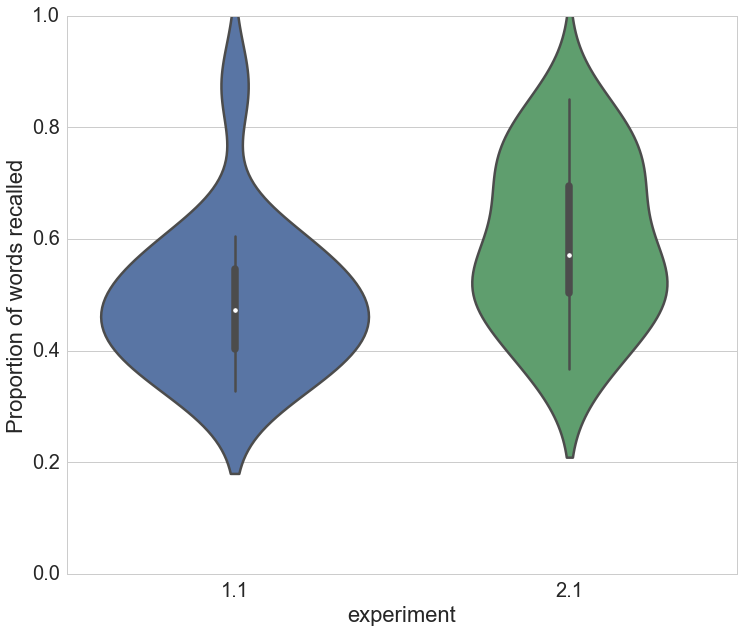

Ttest_indResult(statistic=-2.3031930639087275, pvalue=0.027153801935660152)

In [11]:
plt.figure(figsize=(12, 10))
exp1 = fingerprintsDF['experiment']=='1.1'
exp2 = fingerprintsDF['experiment']=='2.1'
data = fingerprintsDF[(exp1 | exp2)]
data = data.groupby(['subId','experiment']).mean().reset_index(level=['experiment'])
ax = sns.violinplot(y='accuracy',x='experiment', data=data)
plt.ylabel('Proportion of words recalled')
plt.ylim(0,1)
plt.show()

exp1 = data[data['experiment']=='1.1']['accuracy']
exp2 = data[data['experiment']=='2.1']['accuracy']
ttest(exp1,exp2)

# plt.savefig('avgAcc_exp1&2.pdf',format='pdf')

### avg accuracy for exp 1 and 2 together - first half

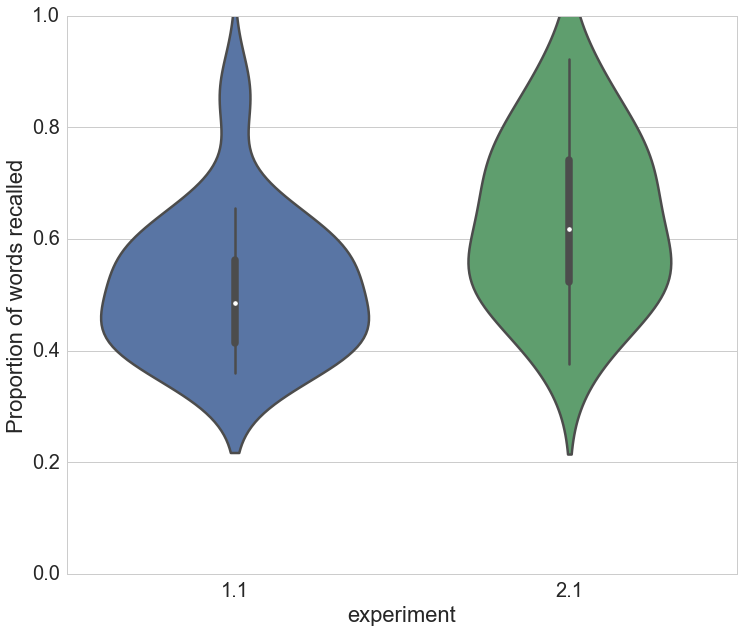

Ttest_indResult(statistic=-2.5267284952200608, pvalue=0.016049626372742123)

In [12]:
plt.figure(figsize=(12, 10))
exp1 = fingerprintsDF['experiment']=='1.1'
exp2 = fingerprintsDF['experiment']=='2.1'
firsthalf = fingerprintsDF['listNum']<8
data = fingerprintsDF[(exp1 | exp2) & firsthalf].groupby(['subId','experiment']).mean().reset_index(level=['experiment'])
ax = sns.violinplot(y='accuracy',x='experiment', data=data)
plt.ylim(0,1)
plt.ylabel('Proportion of words recalled')
plt.show()

exp1 = data[data['experiment']=='1.1']['accuracy']
exp2 = data[data['experiment']=='2.1']['accuracy']
ttest(exp1,exp2)

# plt.savefig('avgAcc_exp1&2_firstHalf.pdf',format='pdf')

### avg accuracy for exp 1 and 2 together - second half

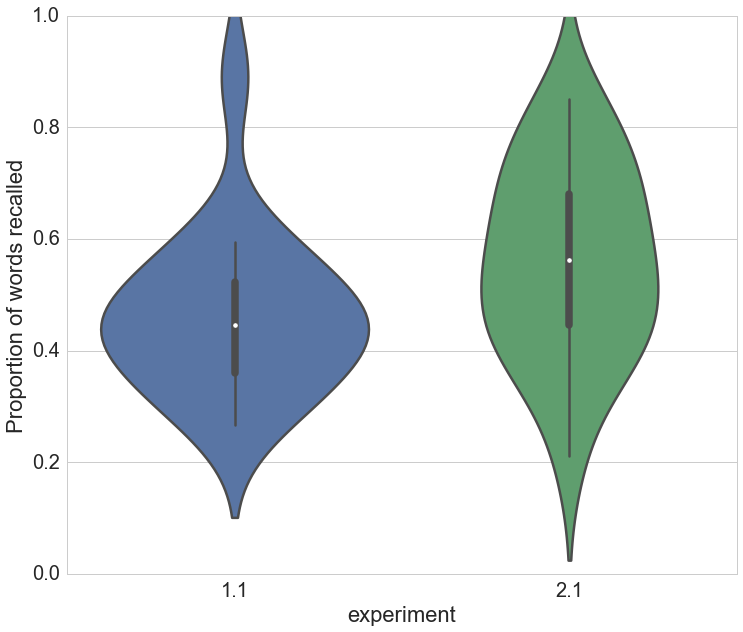

Ttest_indResult(statistic=-1.8219313440003557, pvalue=0.076782085012040396)

In [13]:
plt.figure(figsize=(12, 10))
sns.set_style("whitegrid")
exp1 = fingerprintsDF['experiment']=='1.1'
exp2 = fingerprintsDF['experiment']=='2.1'
secondhalf = fingerprintsDF['listNum']>7
data = fingerprintsDF[(exp1 | exp2) & secondhalf].groupby(['subId','experiment']).mean().reset_index(level=['experiment'])
ax = sns.violinplot(y='accuracy',x='experiment', data=data)
plt.ylabel('Proportion of words recalled')
plt.ylim(0,1)
plt.show()

exp1 = data[data['experiment']=='1.1']['accuracy']
exp2 = data[data['experiment']=='2.1']['accuracy']
ttest(exp1,exp2)

# plt.savefig('avgAcc_exp1&2_secondHalf.pdf',format='pdf')

### avg fingerprint for exp 1

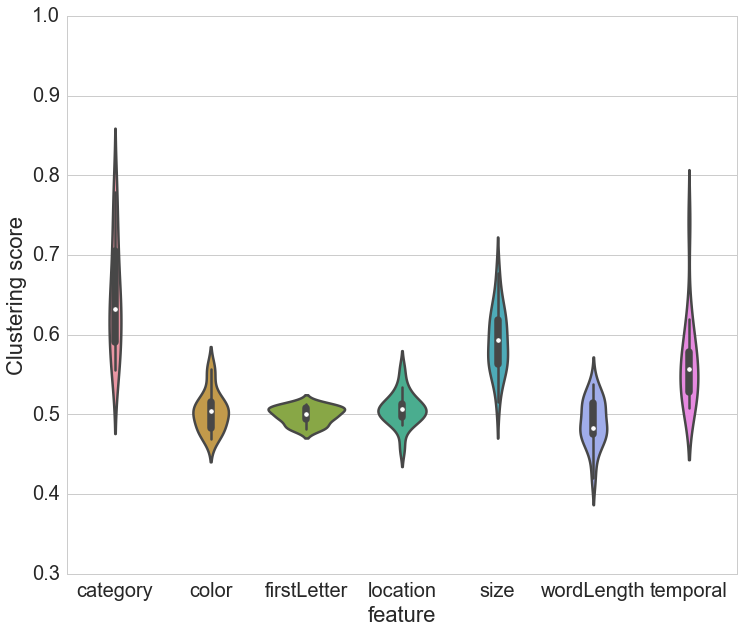

In [14]:
plt.figure(figsize=(12, 10))
exp1 = fingerprintsDF['experiment']=='1.1'
data = fingerprintsDF[exp1].groupby(['subId','experiment','feature']).mean().reset_index(level=['experiment','feature'])
ax = sns.violinplot(y='value',x='feature', data=data,order=['category','color','firstLetter', 'location','size','wordLength','temporal'])
plt.ylabel('Clustering score')
plt.ylim(.3,1)
plt.show()

# plt.savefig('avgFingerprint_exp1.pdf',format='pdf')

### avg fingerprint for exp 2

(0.3, 1)

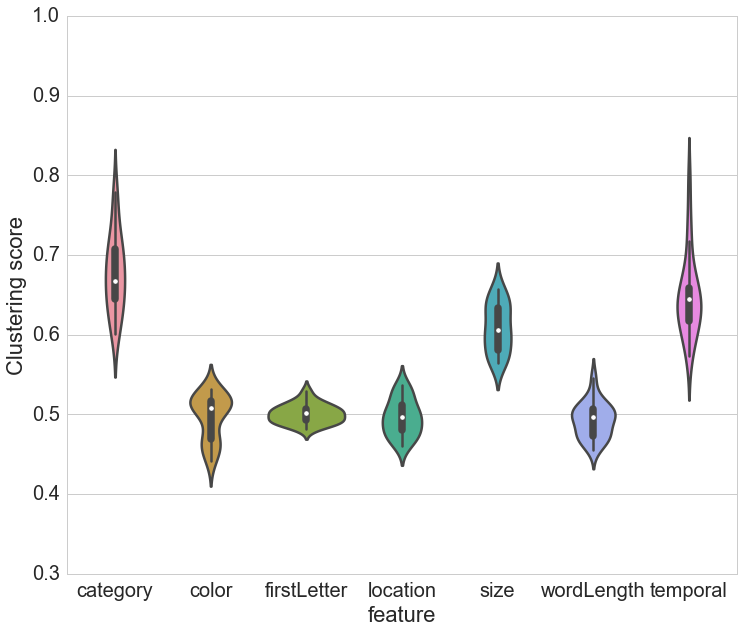

In [15]:
plt.figure(figsize=(12, 10))
exp2 = fingerprintsDF['experiment']=='2.1'
data = fingerprintsDF[exp2].groupby(['subId','experiment','feature']).mean().reset_index(level=['experiment','feature'])
ax = sns.violinplot(y='value',x='feature', data=data,order=['category','color','firstLetter', 'location','size','wordLength','temporal'])
plt.ylabel('Clustering score')
plt.ylim(.3,1)

#plt.savefig('avgFingerprint_exp2.pdf',format='pdf')

### avg fingerprint for exp 1 and 2 together

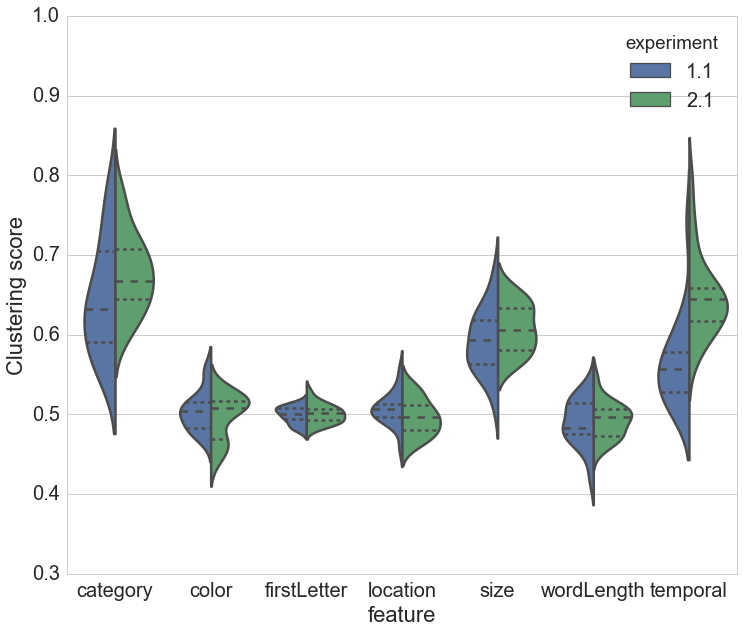

('category ttest (two-sided)', Ttest_indResult(statistic=-1.6236750967538813, pvalue=0.1131705623272828))
('color ttest (two-sided)', Ttest_indResult(statistic=0.7498392089925785, pvalue=0.45822413305237131))
('firstLetter ttest (two-sided)', Ttest_indResult(statistic=-0.46176606596056757, pvalue=0.64702744633822984))
('location ttest (two-sided)', Ttest_indResult(statistic=1.4719265450821675, pvalue=0.14972958879763112))
('size ttest (two-sided)', Ttest_indResult(statistic=-1.4641845178565289, pvalue=0.15182194384678846))
('temporal ttest (two-sided)', Ttest_indResult(statistic=-4.7634174901803386, pvalue=3.0888117089493828e-05))
('wordLength ttest (two-sided)', Ttest_indResult(statistic=-0.41193874929860391, pvalue=0.68282690976498117))


In [16]:
plt.figure(figsize=(12, 10))
exp1 = fingerprintsDF['experiment']=='1.1'
exp2 = fingerprintsDF['experiment']=='2.1'
data = fingerprintsDF[exp1 | exp2].groupby(['subId','experiment','feature']).mean().reset_index(level=['experiment','feature'])
ax = sns.violinplot(y='value',x='feature',hue='experiment',data=data,split=True,scale="count", inner="quartile",order=['category','color','firstLetter', 'location','size','wordLength','temporal'])
plt.ylabel('Clustering score')
plt.ylim(.3,1)
plt.show()

exp1=data['experiment']=='1.1'
exp2=data['experiment']=='2.1'

for feature in ['category','color','firstLetter','location','size','temporal','wordLength']:
    featuren=data['feature']==feature
    data1=data[exp1&featuren]['value']
    data2=data[exp2&featuren]['value']
    print(feature + ' ttest (two-sided)',ttest(data1,data2))
    
# plt.savefig('avgFingerprint_exp1&2.pdf',format='pdf')

### avg fingerprint for exp 1 and 2 together - first half

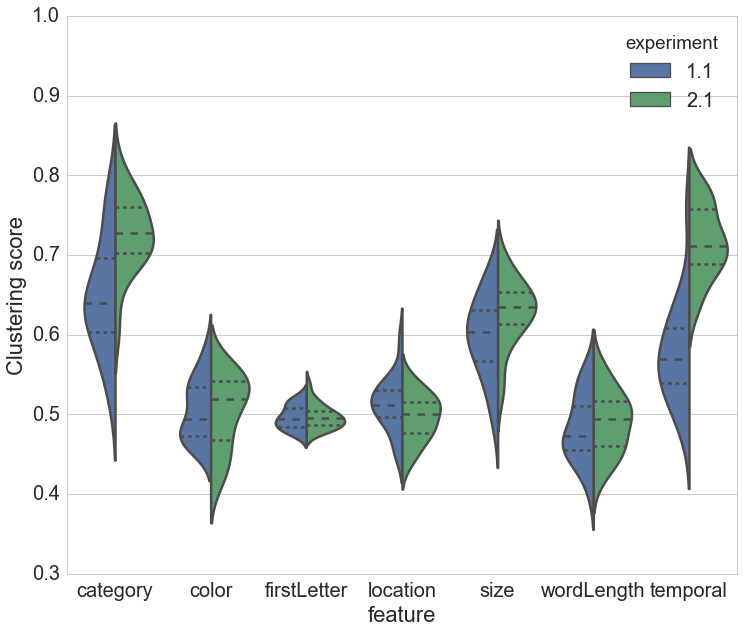

('category ttest (two-sided)', Ttest_indResult(statistic=nan, pvalue=nan))
('color ttest (two-sided)', Ttest_indResult(statistic=nan, pvalue=nan))
('firstLetter ttest (two-sided)', Ttest_indResult(statistic=nan, pvalue=nan))
('location ttest (two-sided)', Ttest_indResult(statistic=nan, pvalue=nan))
('size ttest (two-sided)', Ttest_indResult(statistic=nan, pvalue=nan))
('temporal ttest (two-sided)', Ttest_indResult(statistic=nan, pvalue=nan))
('wordLength ttest (two-sided)', Ttest_indResult(statistic=nan, pvalue=nan))


In [17]:
plt.figure(figsize=(12, 10))
exp1 = fingerprintsDF['experiment']=='1.1'
exp2 = fingerprintsDF['experiment']=='2.1'
firsthalf = fingerprintsDF['listNum']<8
data = fingerprintsDF[(exp1 | exp2) & firsthalf].groupby(['subId','experiment','feature']).mean().reset_index(level=['experiment','feature'])
ax = sns.violinplot(y='value',x='feature',hue='experiment',data=data,split=True,scale="count", inner="quartile",order=['category','color','firstLetter', 'location','size','wordLength','temporal'])
plt.ylabel('Clustering score')
plt.ylim(.3,1)
plt.show()

exp1=data['experiment']=='1.1'
exp2=data['experiment']=='3.2'

for feature in ['category','color','firstLetter','location','size','temporal','wordLength']:
    featuren=data['feature']==feature
    data1=data[exp1&featuren]['value']
    data2=data[exp2&featuren]['value']
    print(feature + ' ttest (two-sided)',ttest(data1,data2))
    
# plt.savefig('avgFingerprint_exp1&2_firstHalf.pdf',format='pdf')

### avg fingerprint for exp 1 and 2 together - second half

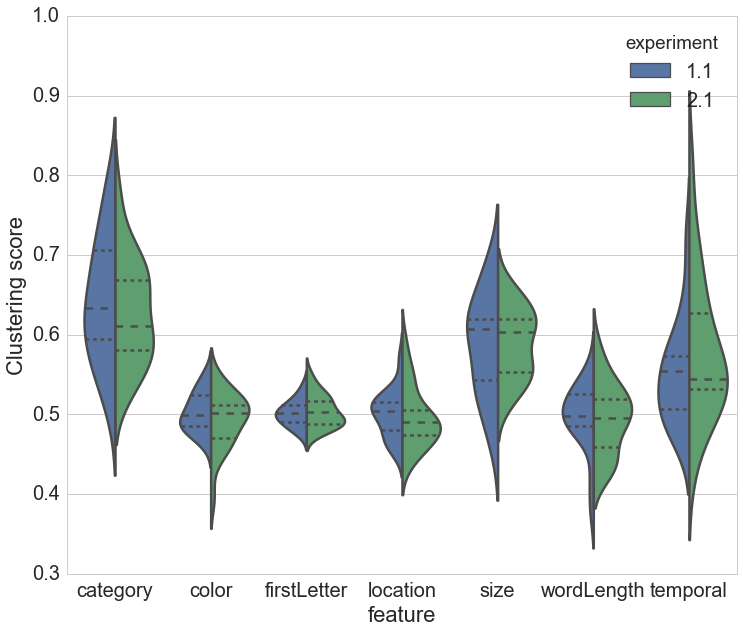

('category ttest (two-sided)', Ttest_indResult(statistic=nan, pvalue=nan))
('color ttest (two-sided)', Ttest_indResult(statistic=nan, pvalue=nan))
('firstLetter ttest (two-sided)', Ttest_indResult(statistic=nan, pvalue=nan))
('location ttest (two-sided)', Ttest_indResult(statistic=nan, pvalue=nan))
('size ttest (two-sided)', Ttest_indResult(statistic=nan, pvalue=nan))
('temporal ttest (two-sided)', Ttest_indResult(statistic=nan, pvalue=nan))
('wordLength ttest (two-sided)', Ttest_indResult(statistic=nan, pvalue=nan))


In [18]:
plt.figure(figsize=(12, 10))
exp1 = fingerprintsDF['experiment']=='1.1'
exp2 = fingerprintsDF['experiment']=='2.1'
secondhalf = fingerprintsDF['listNum']>7
data = fingerprintsDF[(exp1 | exp2) & secondhalf].groupby(['subId','experiment','feature']).mean().reset_index(level=['experiment','feature'])
ax = sns.violinplot(y='value',x='feature',hue='experiment',data=data,split=True,scale="count", inner="quartile",order=['category','color','firstLetter', 'location','size','wordLength','temporal'])
plt.ylabel('Clustering score')
plt.ylim(.3,1)
plt.show()

exp1=data['experiment']=='1.1'
exp2=data['experiment']=='3.2'

for feature in ['category','color','firstLetter','location','size','temporal','wordLength']:
    featuren=data['feature']==feature
    data1=data[exp1&featuren]['value']
    data2=data[exp2&featuren]['value']
    print(feature + ' ttest (two-sided)',ttest(data1,data2))
    
# plt.savefig('avgFingerprint_exp1&2_secondHalf.pdf',format='pdf')

### avg fingerprint for exp 1 and 2 together - second half - split by accuracy

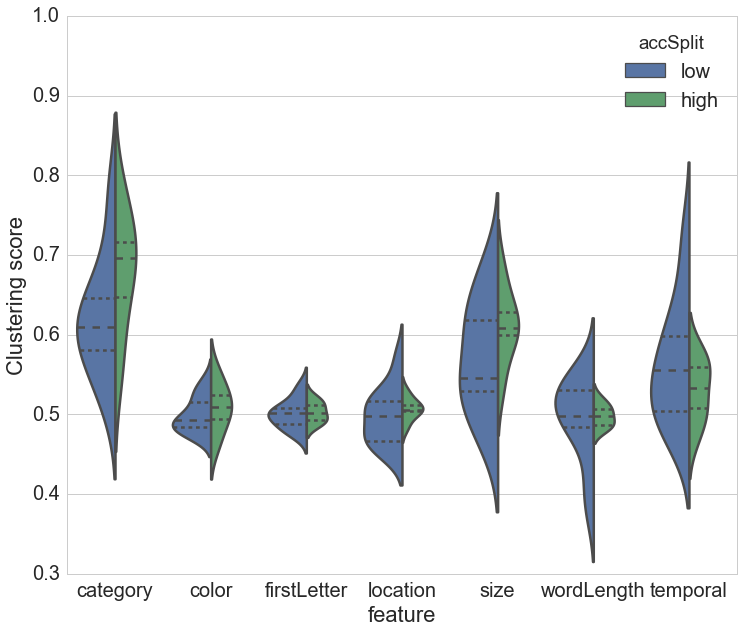

In [19]:
plt.figure(figsize=(12, 10))
exp1 = fingerprintsDF['experiment']=='1.1'
exp2 = fingerprintsDF['experiment']=='2.1'
secondhalf = fingerprintsDF['listNum']>7
data = fingerprintsDF[(exp1) & secondhalf].groupby(['subId','experiment','feature']).mean().reset_index(level=['experiment','feature'])
accMean = fingerprintsDF[(exp1) & secondhalf].groupby(['subId']).mean()['accuracy'].mean()

def f(row):
    if row['accuracy'] > accMean:
        val = 'high'
    else:
        val = 'low'
    return val

data['accSplit'] = data.apply(f, axis=1)

ax = sns.violinplot(y='value',x='feature',hue='accSplit',hue_order=['low','high'],data=data,split=True, scale="count", inner="quartile",order=['category','color','firstLetter', 'location','size','wordLength','temporal'])
plt.ylabel('Clustering score')
plt.ylim(.3,1)
plt.show()

# high=data['accSplit']=='high'
# low=data['accSplit']=='low'

# for feature in ['category','color','firstLetter','location','size','temporal','wordLength']:
#     featuren=data['feature']==feature
#     data1=data[high&featuren]['value']
#     data2=data[low&featuren]['value']
#     print(feature + ' ttest (two-sided)',ttest(data1,data2))

# plt.savefig('avgFingerprint_exp1_secondHalf_accSplit.pdf',format='pdf')

### avg fingerprint for exp 1 and 2 together - second half - split by accuracy

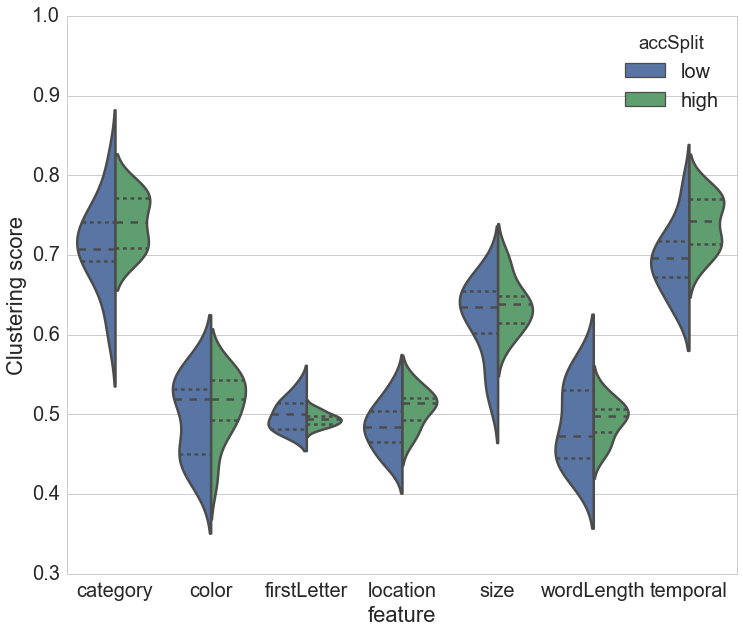

In [20]:
plt.figure(figsize=(12, 10))
exp1 = fingerprintsDF['experiment']=='1.1'
exp2 = fingerprintsDF['experiment']=='2.1'
secondhalf = fingerprintsDF['listNum']<8
data = fingerprintsDF[(exp2) & secondhalf].groupby(['subId','experiment','feature']).mean().reset_index(level=['experiment','feature'])
accMean = fingerprintsDF[(exp2) & secondhalf].groupby(['subId']).mean()['accuracy'].mean()

def f(row):
    if row['accuracy'] > accMean:
        val = 'high'
    else:
        val = 'low'
    return val

data['accSplit'] = data.apply(f, axis=1)

ax = sns.violinplot(y='value',x='feature',hue='accSplit',hue_order=['low','high'],data=data,split=True, scale="count", inner="quartile",order=['category','color','firstLetter', 'location','size','wordLength','temporal'])
plt.ylabel('Clustering score')
plt.ylim(.3,1)
plt.show()

# high=data['accSplit']=='high'
# low=data['accSplit']=='low'

# for feature in ['category','color','firstLetter','location','size','temporal','wordLength']:
#     featuren=data['feature']==feature
#     data1=data[high&featuren]['value']
#     data2=data[low&featuren]['value']
#     print(feature + ' ttest (two-sided)',ttest(data1,data2))

#plt.savefig('avgFingerprint_exp2_firstHalf_accSplit.pdf',format='pdf')


### avg fingerprint for exp 1 and 2 together - second half - split by accuracy

(0.3, 1)

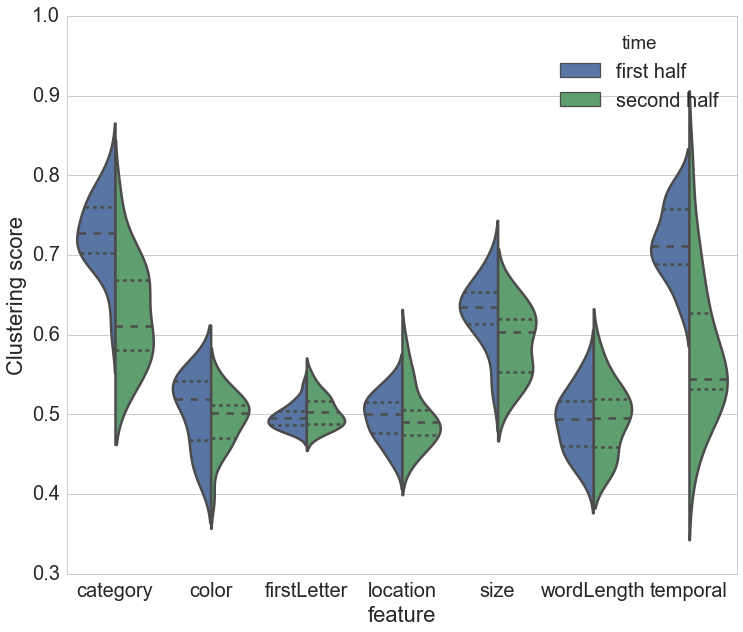

In [21]:
plt.figure(figsize=(12, 10))
exp1 = fingerprintsDF['experiment']=='1.1'
exp2 = fingerprintsDF['experiment']=='2.1'
def f(row):
    if row['listNum'] < 8 :
        val = 'first half'
    else:
        val = 'second half'
    return val

fingerprintsDF['time'] = fingerprintsDF.apply(f, axis=1)

data = fingerprintsDF[exp2].groupby(['subId','time','feature']).mean().reset_index(level=['feature','time'])
ax = sns.violinplot(y='value',x='feature',hue='time',hue_order=['first half','second half'],data=data,split=True, scale="count", inner="quartile",order=['category','color','firstLetter', 'location','size','wordLength','temporal'])
plt.ylabel('Clustering score')
plt.ylim(.3,1)
# plt.show()

# plt.savefig('avgFingerprint_exp2_splitByTime.pdf',format='pdf')
# plt.show()
# # high=data['accSplit']=='high'
# # low=data['accSplit']=='low'

# # for feature in ['category','color','firstLetter','location','size','temporal','wordLength']:
# #     featuren=data['feature']==feature
# #     data1=data[high&featuren]['value']
# #     data2=data[low&featuren]['value']
# #     print(feature + ' ttest (two-sided)',ttest(data1,data2))
# data

In [22]:
# exp1 = fingerprintsDF['experiment']=='1.1'
# exp2 = fingerprintsDF['experiment']=='2.1'
# secondHalf = fingerprintsDF['listNum']>7
# feature=fingerprintsDF['feature']=='temporal'
# data = fingerprintsDF[exp1 & feature].groupby(['subId','feature']).mean().reset_index(level=['feature'])
# data = data[['feature','accuracy','value']]

# g = sns.pairplot(data,hue='feature')
# plt.show()

# feature='temporal'
# a=data[data['feature']==feature]['accuracy']
# b=data[data['feature']==feature]['value']
# import scipy
# print(scipy.stats.pearsonr(a,b))

# corrs={}
# corrs['category']=0.43111982873068738
# corrs['color']=0.042551908675165041
# corrs['size']=0.56232253397336707
# corrs['location']=-0.15929961652715122
# corrs['wordLength']=0.057218271958420434
# corrs['firstLetter']=0.50747948723671299
# corrs['temporal']=-0.52346593256870289

# x=['category','color','size','location','wordLength','firstLetter','temporal']
# y=['clustering score / recall accuracy correlation']
# data = pd.Series(corrs)
# sns.barplot(data=data,y=[key for key in corrs])